## goal is to make a simple structure that can plot clusters, models, and data on the same plot

In [1]:
import os
notebook_wd = os.getcwd()

In [2]:
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
os.chdir(os.path.join(notebook_wd, '..'))
from src.d00_utils.conf_utils import *

In [4]:
compounds, water = load_compounds()
exp_droplet_nh3g = load_experiments(['bd_nh3g'])
constants = load_constants()
paths = load_paths()
exp_droplet_nh3g

{'bd_nh3g': {'raw_data_file': '190924-butenedial-nh3g-droplets.csv',
  'composition': {'Butenedial': 0.75, 'PEG-6': 0.2},
  'solution_name': ['butenedial-peg6-181016', 'butenedial-peg6-181018'],
  'bad_idx': None,
  'idx_range': None,
  'trap_time': None,
  'other_query': 'p283>=10000 and (solution=="butenedial-peg6-181016" or solution=="butenedial-peg6-181018")',
  'y_col': 'mz84_mz283',
  'p283_cutoff': 30000,
  'columns_to_keep': ['trapped',
   'solution',
   'nominal_nh3_mM',
   'mz84_mz283',
   'mz85_mz283',
   'mz149_mz283']}}

In [5]:
# created a new plotting function
from src.d00_utils.data_utils import import_ms_data
from src.d05_reporting.plot_ms_data import plot_ms_data

In [6]:
df_processed = import_ms_data(paths['processed_data'])
df_processed.columns

Index(['mins', 'solution', 'nominal_nh3_mM', 'mz84_mz283', 'mz85_mz283',
       'mz149_mz283', 'experiment'],
      dtype='object')

In [10]:
from src.d02_extraction.cluster_ms_data import create_clustered_statistics_dataframe
df_clustered = create_clustered_statistics_dataframe(paths['processed_data'], col_to_cluster='mins', 
                                                     y_cols_to_keep=['mz84_mz283', 'mz85_mz283', 'mz149_mz283'],
                                                     max_points_per_cluster=3, save_clustered_data=True)

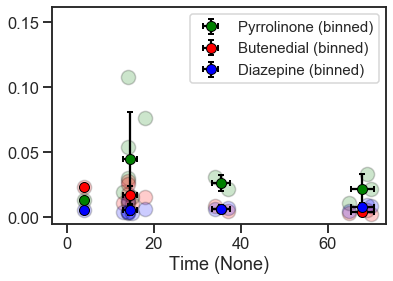

In [11]:
plot_ms_data(df_data=df_processed[df_processed.experiment == 'bd_nh3g_29'], x_data_col='mins', y_data_cols=['mz84_mz283', 'mz85_mz283', 'mz149_mz283'],
             series_labels=['Pyrrolinone', 'Butenedial', 'Diazepine'], series_colors=['green', 'red', 'blue'], save_fig=True,
             df_model=None, x_model_col=None, y_model_cols=None,
             df_cluster=df_clustered[df_clustered.experiment == 'bd_nh3g_29'], x_cluster_col='mins', y_cluster_cols=['mz84_mz283', 'mz85_mz283', 'mz149_mz283'],
             x_label=None, y_label=None, series_title=None)

In [46]:
def plot_ms_data(df_data, x_data_col, y_data_cols,
                 series_labels, series_colors, save_fig=False, ax=None,
                 df_model=None, x_model_col=None, y_model_cols=None,
                 df_cluster=None, x_cluster_col=None, y_cluster_cols=None,
                 x_label=None, y_label=None, series_title=None):
    """
    """

    sns.set(style="ticks")
    sns.set_context("talk")

    # find x and y max
    x_max_data = x_max_model = x_max_cluster = 0
    y_max_data = y_max_model = y_max_cluster = 0
    x_max_data = df_data[x_data_col].max()
    y_max_data = np.nanmax(df_data[y_data_cols].max())

    if df_model is not None:
        x_max_model = df_model[x_model_col].max()
        y_max_model = np.nanmax(df_model[y_model_cols].max().values)
    if df_cluster is not None:
        x_max_cluster = df_cluster[x_cluster_col].max()
        y_max_cluster = np.nanmax(df_cluster[y_cluster_cols].max().values)

    x_max = np.nanmax([x_max_data, x_max_model, x_max_cluster])
    y_max = np.nanmax([y_max_data, y_max_model, y_max_cluster])

    if ax is not None:
        ax = ax
    else:
        fig, ax = plt.subplots()

    N_series = len(y_data_cols)
    for tick in range(N_series):
        
        xs = df_data[x_data_col]
        ys = df_data[y_data_cols[tick]]

        if df_cluster is not None:
            x_clusters = df_cluster[x_cluster_col]
            y_clusters = df_cluster[y_cluster_cols[tick]]
            x_err_col = x_cluster_col + '_std'
            y_err_col = y_cluster_cols[tick] + '_std'
            x_errs = df_cluster[x_err_col]
            y_errs = df_cluster[y_err_col]

            ax.errorbar(x=x_clusters, y=y_clusters, xerr=x_errs, yerr=y_errs,
                         ls='', marker='o', markersize=10, markeredgecolor='black',
                         capsize=3, capthick=2, ecolor='black',
                         color=series_colors[tick], label='%s (binned)' % series_labels[tick])

            ax.scatter(xs, ys, color=series_colors[tick], s=200, alpha=0.2, edgecolor='black')
        else:
            ax.scatter(xs, ys, label=series_labels[tick], color=series_colors[tick], s=200, alpha=1, edgecolor='black')

    if df_model is not None:
        xs_model = df_model[x_model_col]
        ys_model = df_model[y_model_cols[tick]]
        ax.plot(xs_model, ys_model, lw=2, color=series_colors[tick], label='%s (predicted)' % series_labels[tick])
    
    ax.set(xlabel=x_label, ylabel=y_label,
           ylim=(-y_max * 0.05, y_max * 1.5), xlim=(-x_max * 0.05, x_max * 1.05))

    if series_title is None:
        ax.legend(fontsize='small')
    else:
        ax.legend(title=series_title, fontsize='small')

    if save_fig:
        project_dir = get_project_directory()
        today_str = date.today().strftime("%Y%m%d")
        expt_strings = '-'.join(series_labels)
        file_name = today_str[2:] + '-' + expt_strings + '.png'
        file_path = os.path.join(project_dir, 'results', 'figs_out', file_name)
        plt.savefig(file_path, bbox_inches='tight', dpi=300, transparent=True)
        
    return ax

In [47]:
# make figure with subplots
def subplot_ms_data(df_data, x_data_col, y_data_cols,
                    series_labels, series_colors, save_fig=False,
                    df_cluster=None, x_cluster_col=None, y_cluster_cols=None,
                    df_model=None, x_model_col=None, y_model_cols=None,
                    big_x_label=None, big_y_label=None):
    
    N_plots = len(y_data_cols)
    fig, ax = plt.subplots(N_plots, 1, figsize=(4, N_plots*1.75), sharex=True)
    fig.subplots_adjust(0,0,1,1,0,0)
    
    # enable common x and y axis labels
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(big_x_label)
    plt.ylabel(big_y_label)

    for tick in range(N_plots):
        y_data_col = [y_data_cols[tick]]
        y_cluster_col = [y_cluster_cols[tick]]
        y_model_col = [y_model_cols[tick]]
        series_color = [series_colors[tick]]
        series_label = [series_labels[tick]]
        ax[tick] = plot_ms_data(df_data, x_data_col, y_data_col,
                                series_label, series_color, save_fig=False, ax=ax[tick],
                                df_model=df_model, x_model_col=x_model_col, y_model_cols=y_model_col,
                                df_cluster=df_cluster, x_cluster_col=x_cluster_col, y_cluster_cols=y_cluster_col,
                                x_label=None, y_label=None, series_title=None)

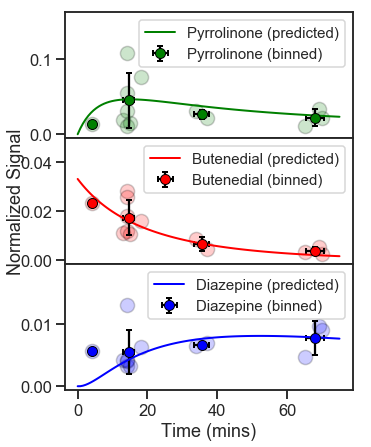

In [72]:
y_data_cols = ['mz84_mz283', 'mz85_mz283', 'mz149_mz283']
labels = ['Pyrrolinone', 'Butenedial', 'Diazepine']
y_cluster_cols = ['mz84_mz283', 'mz85_mz283', 'mz149_mz283']
colors = ['green', 'red', 'blue']

subplot_ms_data(df_data=df_processed[df_processed.experiment=='bd_nh3g_29'], x_data_col='mins', y_data_cols=y_data_cols,
                    series_labels=labels, series_colors=colors, save_fig=False,
                    df_cluster=df_clustered[df_clustered.experiment=='bd_nh3g_29'], x_cluster_col='mins', y_cluster_cols=['mz84_mz283', 'mz85_mz283', 'mz149_mz283'],
                    df_model=df_model, x_model_col='mins', y_model_cols=['84_sig','85_sig','149_sig'],
                    big_x_label='Time (mins)', big_y_label='Normalized Signal')

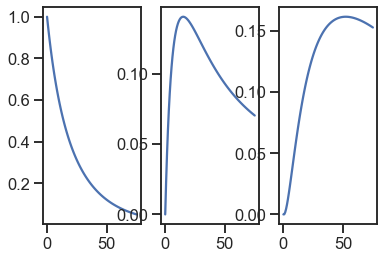

In [71]:
## Toy model to view PYR concentrations under varying NH3g conditions
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

kevap_pyr = 1/170
kevap_bd = 1/85
kevap_dia = 1/1000
krxn = 1/30
krxn2 = 1/10

fig, ax = plt.subplots(1, 3)
def toymod(y, t): 
    bd, pyr, dia = y
    dydt = [-krxn*bd - 2*kevap_bd*bd*bd, krxn*bd*bd - kevap_pyr*pyr - krxn2*pyr*bd, krxn2*pyr*bd - kevap_dia]

    return dydt
    
ts = np.linspace(0, 75, 100)
results = odeint(
    toymod, 
    y0=[1, 0, 0], t=ts)

df_model = pd.DataFrame()
df_model['mins'] = ts
df_model['85_sig'] = results[:, 0]*0.033
df_model['84_sig'] = results[:, 1]*0.33
df_model['149_sig'] = results[:, 2]*0.05

ax[0].plot(ts, results[:, 0])
ax[1].plot(ts, results[:, 1])
ax[2].plot(ts, results[:, 2])

In [73]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [75]:
df_processed.head()

,mins,solution,nominal_nh3_mM,mz84_mz283,mz85_mz283,mz149_mz283,experiment
0,3,butenedial-peg6-181016,0.0,0.001706,0.005410,0.000648,bd_nh3g_00
1,3,butenedial-peg6-181016,1450.0,0.027495,0.001060,0.009438,bd_nh3g_14500
2,3,butenedial-peg6-181016,0.0,0.003821,0.007328,0.000598,bd_nh3g_00
3,4,butenedial-peg6-181016,0.0,0.000974,0.006895,0.001039,bd_nh3g_00
4,18,butenedial-peg6-181016,1450.0,0.022977,0.000669,0.022730,bd_nh3g_14500


In [110]:
x = df_processed[df_processed.experiment == 'bd_nh3g_29'].mins.values.reshape(-1, 1)
x.shape

(13, 1)

In [111]:
ones = np.ones((x.shape[0], 1))
X = np.c_[ones, x]
X.shape
X

array([[ 1., 18.],
       [ 1., 37.],
       [ 1., 70.],
       [ 1., 34.],
       [ 1., 13.],
       [ 1., 69.],
       [ 1., 14.],
       [ 1., 14.],
       [ 1., 14.],
       [ 1.,  4.],
       [ 1., 15.],
       [ 1., 14.],
       [ 1., 65.]])

In [120]:
y = df_processed[df_processed.experiment == 'bd_nh3g_29'].mz84_mz283.values
lny = np.log(y)
lny

array([-2.57531938, -3.82198423, -3.83322571, -3.4762795 , -3.94695656,
       -3.39300721, -4.50266782, -3.49626958, -2.91517367, -4.3258954 ,
       -4.16764528, -2.22690201, -4.51350502])

In [129]:
reg = LinearRegression().fit(X, lny)
reg.score(X, lny)

b0, b1 = reg.coef_
print(b0, b1)
xs = np.linspace(x.min(), x.max(), 100)
lnyhats = b0 + np.dot(b1, xs)
lnyhats

0.0 -0.004985394848352246


array([-0.01994158, -0.02326518, -0.02658877, -0.02991237, -0.03323597,
       -0.03655956, -0.03988316, -0.04320676, -0.04653035, -0.04985395,
       -0.05317755, -0.05650114, -0.05982474, -0.06314833, -0.06647193,
       -0.06979553, -0.07311912, -0.07644272, -0.07976632, -0.08308991,
       -0.08641351, -0.08973711, -0.0930607 , -0.0963843 , -0.0997079 ,
       -0.10303149, -0.10635509, -0.10967869, -0.11300228, -0.11632588,
       -0.11964948, -0.12297307, -0.12629667, -0.12962027, -0.13294386,
       -0.13626746, -0.13959106, -0.14291465, -0.14623825, -0.14956185,
       -0.15288544, -0.15620904, -0.15953264, -0.16285623, -0.16617983,
       -0.16950342, -0.17282702, -0.17615062, -0.17947421, -0.18279781,
       -0.18612141, -0.189445  , -0.1927686 , -0.1960922 , -0.19941579,
       -0.20273939, -0.20606299, -0.20938658, -0.21271018, -0.21603378,
       -0.21935737, -0.22268097, -0.22600457, -0.22932816, -0.23265176,
       -0.23597536, -0.23929895, -0.24262255, -0.24594615, -0.24

In [128]:
yhats = np.exp(lnyhats)
yhats

array([0.98025594, 0.97700337, 0.9737616 , 0.97053058, 0.96731028,
       0.96410067, 0.96090171, 0.95771336, 0.95453559, 0.95136836,
       0.94821165, 0.94506541, 0.9419296 , 0.93880421, 0.93568918,
       0.93258449, 0.9294901 , 0.92640598, 0.92333209, 0.9202684 ,
       0.91721487, 0.91417148, 0.91113819, 0.90811496, 0.90510176,
       0.90209856, 0.89910533, 0.89612203, 0.89314862, 0.89018508,
       0.88723138, 0.88428747, 0.88135334, 0.87842894, 0.87551424,
       0.87260921, 0.86971383, 0.86682805, 0.86395184, 0.86108518,
       0.85822803, 0.85538036, 0.85254214, 0.84971334, 0.84689393,
       0.84408386, 0.84128313, 0.83849168, 0.8357095 , 0.83293655,
       0.8301728 , 0.82741822, 0.82467278, 0.82193645, 0.8192092 ,
       0.816491  , 0.81378182, 0.81108162, 0.80839039, 0.80570809,
       0.80303468, 0.80037015, 0.79771446, 0.79506758, 0.79242948,
       0.78980014, 0.78717952, 0.78456759, 0.78196434, 0.77936972,
       0.77678371, 0.77420628, 0.7716374 , 0.76907704, 0.76652